In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u # Don't name any variable as u.
%matplotlib inline

In [2]:
def get_flux(delta, transit_total, transit_full_sup, occulation_total, occulation_full_sup, \
             period, planet_lum, split):
    d = delta
    pl = planet_lum
    flux = []
    c = []
    
    time = np.linspace(-period/2, period/2, split)
    p = period/4
    t_t = transit_total/2
    f_t = transit_full_sup/2
    t_o = occulation_total/2
    f_o = occulation_full_sup/2
    for i in range(len(time)):
        if time[i] > (-p-t_o) and time[i] < (-p-f_o):
            flux.append(1.0 + (pl/2)*(1.0 - np.sin(2*np.pi*time[i]/period)) - (pl * (time[i]-(-p-t_o)) / (t_o-f_o)))
            c.append('r')
        elif time[i] > (-p-f_o) and time[i] < (-p+f_o):
            flux.append(1.0)
            c.append('r')
        elif time[i] > (-p+f_o) and time[i] < (-p+t_o):
            flux.append(1.0 + (pl/2)*(1.0 - np.sin(2*np.pi*time[i]/period)) - (pl * ((-p+t_o)-time[i]) / (t_o-f_o)))
            c.append('r')
        elif time[i] > (p-t_t) and time[i] < (p-f_t):
            flux.append(1.0 + (pl/2)*(1.0 - np.sin(2*np.pi*time[i]/period)) - (d * (time[i]-(p-t_t)) / (t_t-f_t)))
            c.append('g')
        elif time[i] > (p-f_t) and time[i] < (p+f_t):
            flux.append(1.0 + (pl/2)*(1.0 - np.sin(2*np.pi*time[i]/period)) - d)
            c.append('g')
        elif time[i] > (p+f_t) and time[i] < (p+t_t):
            flux.append(1.0 + (pl/2)*(1.0 - np.sin(2*np.pi*time[i]/period)) - (d * ((p+t_t)-time[i]) / (t_t-f_t)))
            c.append('g')
        else:
            flux.append(1.0 + (pl/2)*(1.0 - np.sin(2*np.pi*time[i]/period)))
            c.append('b')
    
    return flux, c

In [3]:
class system(object):
    def __init__(self, *args, **kw):
#         self.tT = kw['transit_total']
#         self.tF = kw['transit_full_sup']
        self.P = kw['period']
#         self.d = kw['delta']
#         self.pl = kw['planet_lum']
        self.Rp = kw['planet_radius']
        self.Rs = kw['star_radius']
        self.a = kw['orbit_radius']
        self.i = kw['orbit_inclination']
        self.alb = kw['albedo']
#         self.b = kw['impact_parameter']
        self.e = kw['eccentricity']
        self.w = kw['argument_periastron']
        self.split = kw['split']
        self.delta()
        self.planet_lum()
        self.impact_parameters()
        self.transit_durations()
        
    def delta(self):
        self.d = (self.Rp / self.Rs) ** 2
    
    def planet_lum(self):
        self.pl = self.alb * 1.0 * (self.Rp**2) / (self.a**2)
        
    def impact_parameters(self):
        if self.i == np.pi/2 :
            self.b = 0
        else:
            self.b = self.a * np.cos(self.i) / self.Rs
        self.b_t = self.b * (1 - self.e**2) / (1 + self.e*np.sin(self.w))
        self.b_o = self.b * (1 - self.e**2) / (1 - self.e*np.sin(self.w))
        
    def transit_durations(self):
        prop = (self.P * self.Rs) / (np.pi * self.a)
        ratio = self.Rp / self.Rs        
        self.tT_t = prop * ((((1 + self.Rp / self.Rs) ** 2) - (self.b_t ** 2)) ** 0.5)
        self.tF_t = prop * ((((1 - self.Rp / self.Rs) ** 2) - (self.b_t ** 2)) ** 0.5)
        self.tT_o = prop * ((((1 + self.Rp / self.Rs) ** 2) - (self.b_o ** 2)) ** 0.5)
        self.tF_o = prop * ((((1 - self.Rp / self.Rs) ** 2) - (self.b_o ** 2)) ** 0.5)
        
    def plot(self):    
        flux, color = get_flux(self.d, self.tT_t, self.tF_t, self.tT_o, self.tF_o, self.P, self.pl, self.split)
        t = np.linspace(-self.P/2, self.P/2, self.split)
        fig = plt.figure(figsize=(12,8))
        ax = fig.add_subplot(111)
        ax.scatter(t, flux, s=1, c=color)

    def plot_y_zoom(self, lim):
        flux, color = get_flux(self.d, self.tT_t, self.tF_t, self.tT_o, self.tF_o, self.P, self.pl, self.split)
        t = np.linspace(-self.P/2, self.P/2, self.split)
        fig = plt.figure(figsize=(12,8))
        ax = fig.add_subplot(111, ylim=lim)
        ax.scatter(t, flux, s=1, c=color)
        plt.grid(True)
        
    def plot_zoom(self):
        flux, color = get_flux(self.d, self.tT_t, self.tF_t, self.tT_o, self.tF_o, self.P, self.pl, self.split)
        t = np.linspace(-self.P/2, self.P/2, self.split)
        ind_o_l = int((self.P/4 - self.tT_o) / self.P * self.split)
        ind_o_r = int((self.P/4 + self.tT_o) / self.P * self.split)
        ind_t_l = int((3*self.P/4 - self.tT_t) / self.P * self.split)
        ind_t_r = int((3*self.P/4 + self.tT_t) / self.P * self.split)
        fig, ax = plt.subplots(1, 2, figsize=(12,4))
        ax[0].scatter(t[ind_o_l:ind_o_r], flux[ind_o_l:ind_o_r], s=1, c=color[ind_o_l:ind_o_r])
        ax[1].scatter(t[ind_t_l:ind_t_r], flux[ind_t_l:ind_t_r], s=1, c=color[ind_t_l:ind_t_r])
        
    def params(self):
        print('tT transit', self.tT_t)
        print('tF transit', self.tF_t)
        print('tT occulation', self.tT_o)
        print('tF occulation', self.tF_o)
        print('Period', self.P)
        print('delta', self.d)
        print('planet_lum', self.pl)
        print('Rp', self.Rp)
        print('Rs', self.Rs)
        print('albedo', self.alb)
        print('orbit_radius', self.a)
        print('orbit_inclination', self.i)
        print('impact_parameter transit', self.b_t)
        print('impact_parameter occulation', self.b_o)
        print('eccentricity', self.e)
        print('argument_periastron', self.w)
        

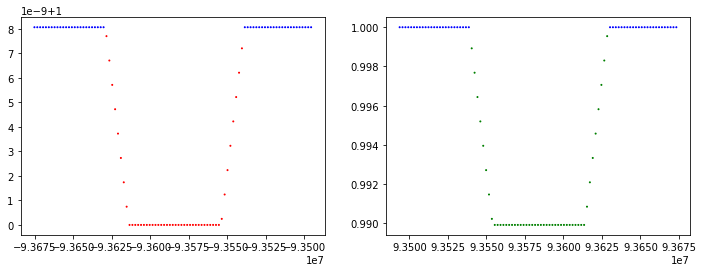

In [4]:
sys = system(period = 4332.59*24*3600, planet_radius = 69911000, star_radius = 696340000, \
             orbit_radius = 778500000000, orbit_inclination = np.pi*0.4998, albedo = 1, \
             eccentricity = 0, argument_periastron = np.pi*1.5, split = 200000)
# Jupiter - Sun system with e = 0
sys.plot_zoom()

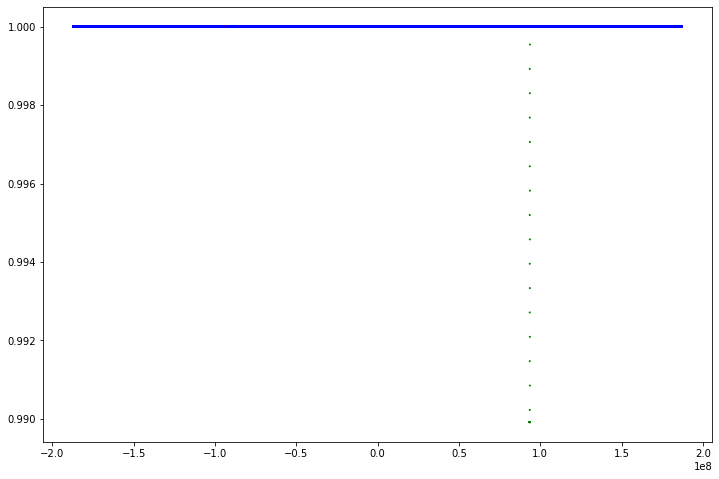

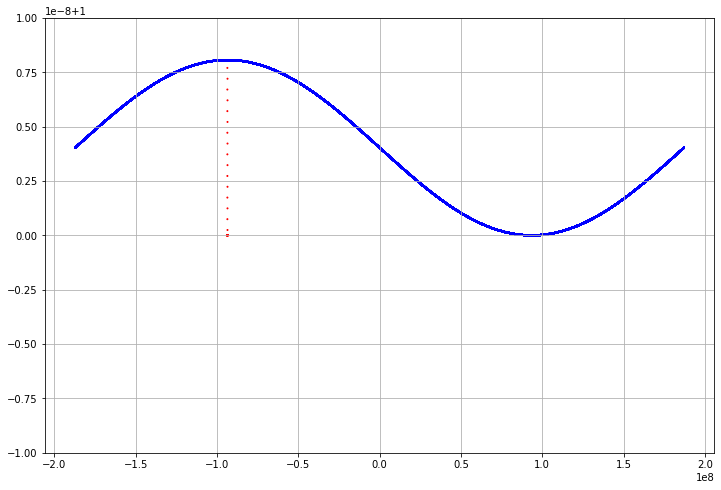

In [5]:
sys.plot()
sys.plot_y_zoom(lim=(0.99999999, 1.00000001))

In [6]:
sys.params()

tT transit 90274.60657150912
tF transit 59897.77508275188
tT occulation 90274.60657150912
tF occulation 59897.77508275188
Period 374335776.0
delta 0.010079717076411147
planet_lum 8.064432194877672e-09
Rp 69911000
Rs 696340000
albedo 1
orbit_radius 778500000000
orbit_inclination 1.5701680082641787
impact_parameter transit 0.70245274431944
impact_parameter occulation 0.70245274431944
eccentricity 0
argument_periastron 4.71238898038469


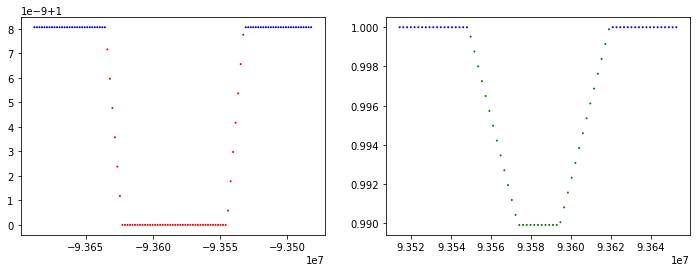

In [7]:
sys = system(period = 4332.59*24*3600, planet_radius = 69911000, star_radius = 696340000, \
             orbit_radius = 778500000000, orbit_inclination = np.pi*0.4998, albedo = 1, \
             eccentricity = 0.25, argument_periastron = np.pi*1.5, split = 200000)
# Jupiter - Sun system with e = 0.25 (to compare)
sys.plot_zoom()

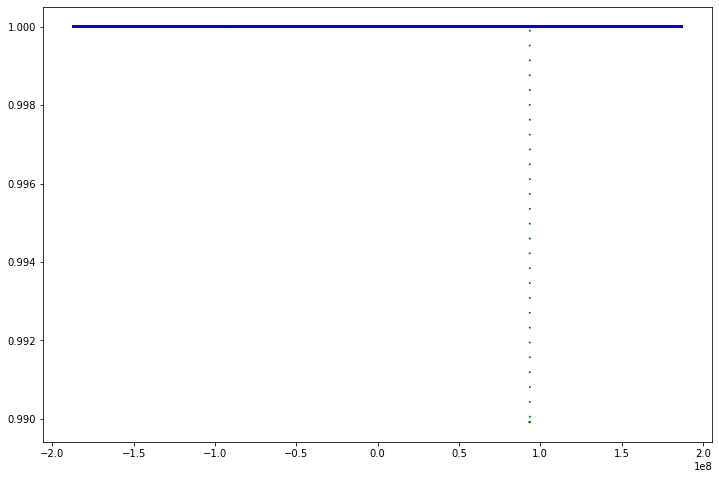

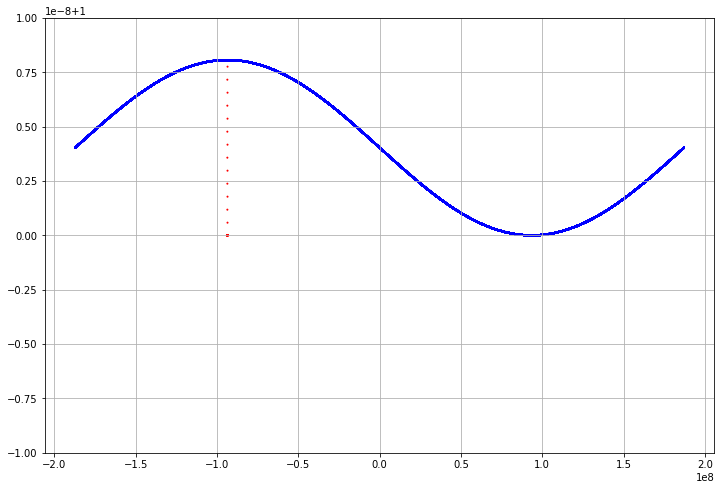

In [8]:
sys.plot()
sys.plot_y_zoom(lim=(0.99999999, 1.00000001))

In [9]:
sys.params()

tT transit 70686.92495565879
tF transit 20853.782100859087
tT occulation 102964.71021581649
tF occulation 77717.24659334142
Period 374335776.0
delta 0.010079717076411147
planet_lum 8.064432194877672e-09
Rp 69911000
Rs 696340000
albedo 1
orbit_radius 778500000000
orbit_inclination 1.5701680082641787
impact_parameter transit 0.8780659303993
impact_parameter occulation 0.52683955823958
eccentricity 0.25
argument_periastron 4.71238898038469


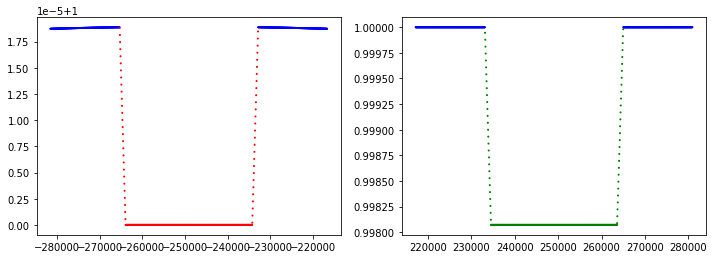

In [10]:
sys = system(period = 11.53*24*3600, planet_radius = 0.1026*696340000, star_radius = 2.336*696340000, \
             orbit_radius = 0.1097*215.032*696340000, orbit_inclination = np.pi*88.9/180, albedo = 1, \
             eccentricity = 0.251, argument_periastron = np.pi*1.5, split = 20000)
# Jupiter - Sun system
sys.plot_zoom()

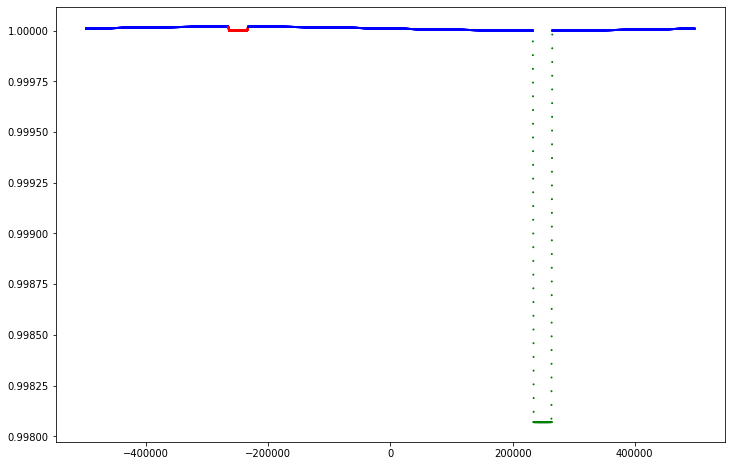

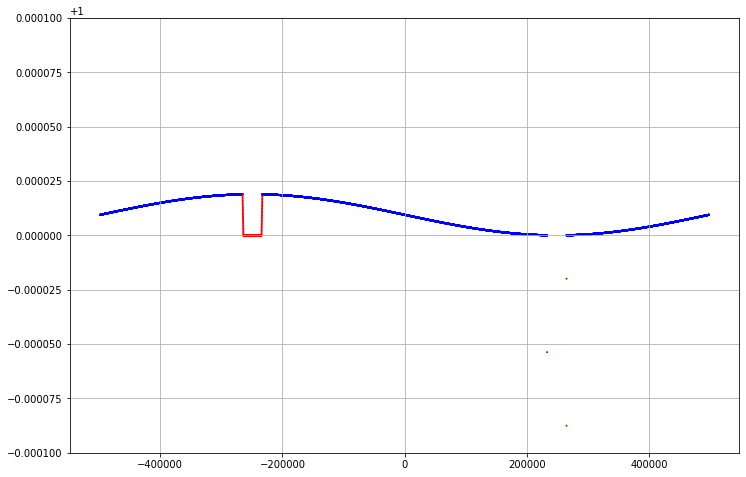

In [11]:
sys.plot()
sys.plot_y_zoom(lim=(0.9999, 1.0001))

In [12]:
sys.params()

tT transit 31884.296762405203
tF transit 29040.812806809656
tT occulation 32462.499158154424
tF occulation 29674.471857814315
Period 996191.9999999999
delta 0.0019290746974103962
planet_lum 1.8918002469946557e-05
Rp 71444484.0
Rs 1626650240.0
albedo 1
orbit_radius 16425971501.936003
orbit_inclination 1.551597705022959
impact_parameter transit 0.24251441960317624
impact_parameter occulation 0.14519848144107037
eccentricity 0.251
argument_periastron 4.71238898038469
